In [1]:
%run ./resources/library.py

In [ ]:
# Run this cell if not using JupyterLab
style_notebook()

# Notebook 4 - Advanced: Analyzing the John Snow Cholera Outbreak Using OpenStreetMaps and Networkx - Part 2

## Learning Objectives

By the end of this notebook, you should be able to:

1. Recall how to load and save `osmnx` street network graphs 
2. Recall how to load data from CSV and pickle files using `pandas`
3. Describe how the three distances, d1, d2 and d3, are computed using `osmnx`
4. Describe how a nested loop works to calculate the route distance between 2 nodes (pumps and deaths)
5. Identify how this algorithm pattern can be used in solving other public health problems.

## Summary of steps

We will carry out the following <font color=red>steps</font>:

<font color=red>Step 1</font> - Read the street network graph, `G`, of Soho district using OSMnx using a set of coordinates in the middle of Soho district. **(We saved this graph in Notebook 2 and we will read it from the graphml file `soho.graphml`.)**  
   
   
<font color=red>Step 2</font> - Load the original data sets from Notebook 1 (pumps and deaths) into `pumps_df` and `deaths_df`.


<font color=red>Step 3</font> - To represent coordinates from the pumps and deaths from the Notebook 1 in OSMnx graph format, we have to find the nearest OSMnx nodes to those points. We will add new columns to the pumps and deaths dataframes to accomodate new information coming from OSMnx. We will also store the short distances between original points to the nearest OSMnx points and store it in the respective dataframes.

<font color=red>Step 4</font> -  To calculate mean distances from death coordinates to pump coordinates we will create a nested loop through records of both dataframes, `pumps_df` and `deaths_df`, for pairwise distance calculations between each pump and death coordinates. We will add the short distances from #1 to the pump point to death point distance and store this in a new dataframe called `routes_df`.

<font color=red>Step 5</font> - We will then create the map representation pump-to-death-points mean distances using `folium` and superimpose this on the markers generated in Notebook 1.

In [2]:
# import osmnx package, use "ox" as alias
import osmnx as ox

# set some configuration parameters for osmnx
# print version of package
ox.config(log_file=True, log_console=True, use_cache=True)

ox.__version__

I0627 11:20:17.860483 139883350333248 utils.py:177] Configured osmnx


'0.10'

Let's read our street network graph from file using the dot function, <font color=red>`load_graphml()`</font>.

In [3]:
G = ox.load_graphml(filename='soho.graphml', folder='outputs')

I0627 11:20:22.444550 139883350333248 utils.py:177] Converting node and edge attribute data types
I0627 11:20:22.520253 139883350333248 utils.py:177] Loaded graph with 1,389 nodes and 3,900 edges in 0.28 seconds from "outputs/soho.graphml"


I0627 11:20:23.666146 139883350333248 utils.py:177] Begin plotting the graph...
I0627 11:20:23.791837 139883350333248 utils.py:177] Created GeoDataFrame "unnamed_edges" from graph in 0.12 seconds
I0627 11:20:23.998138 139883350333248 utils.py:177] Drew the graph edges in 0.07 seconds


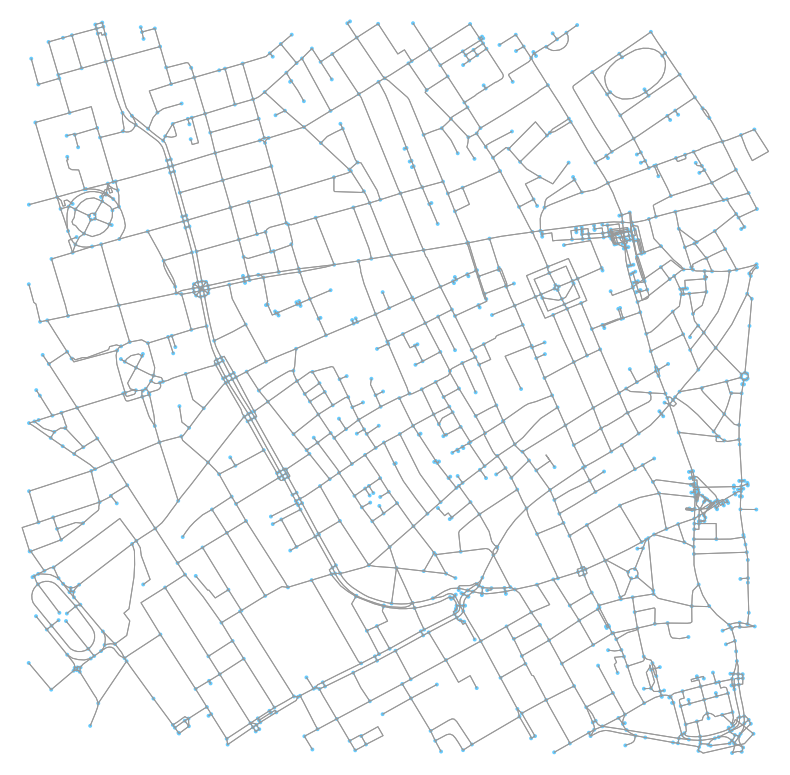

I0627 11:20:24.268643 139883350333248 utils.py:177] Showed the plot in 0.21 seconds


In [4]:
fig, ax = ox.plot_graph(G,  fig_height=14, fig_width=None)

## Step 2. Load pumps and deaths data sets

Let's read the data set from a pickle file using the dot function <font color=red>`read_pickle()`</font>. 

In [5]:
import pandas as pd

# Read CSV with cholera deaths.
deaths_df = pd.read_pickle('outputs/deaths_mean_center_df.pickle')

# display dataframe records
deaths_df.head()

,FID,DEATHS,LON,LAT,product_LAT,product_LON
0,0,3,-0.137930,51.513418,154.540254,-0.413790
1,1,2,-0.137883,51.513361,103.026722,-0.275766
2,2,1,-0.137853,51.513317,51.513317,-0.137853
3,3,1,-0.137812,51.513262,51.513262,-0.137812
4,4,4,-0.137767,51.513204,206.052816,-0.551068


This dataframe has two additional columns, `product_LAT` and `product_LON` resulting from computing for the mean center in Notebook 2.

Next, let's read the pickle file for pumps.

In [6]:
# Read CSV with pumps.
pumps_df = pd.read_pickle('outputs/pumps_df.pickle')

pumps_df

,FID,LON,LAT
0,250,-0.136668,51.513341
1,251,-0.139586,51.513876
2,252,-0.139671,51.514906
3,253,-0.131630,51.512354
4,254,-0.133594,51.512139
5,255,-0.135919,51.511542
6,256,-0.133962,51.510019
7,257,-0.138199,51.511295


## Step 3: Set up `pumps_df` and `deaths_df` dataframes to store additional `osmnx` information

### Set up `pumps_df` dataframe for analysis

Let's create five new columns for `pumps_df`:
1. Two (2),<font color=red>`pumps_df['GLON']`</font> and <font color=red>`pumps_df['GLAT']`</font>, to store coordinates from the OSMnx graph nodes that correspond to original pump coordinates.
2. <font color=red>`pumps_df['DISTANCE']`</font> to store distance between original pump coordinates and OSMnx graph coordinates
3. <font color=red>`pumps_df['NODE']`</font> to store the node ID of an OSMnx graph node coordinate 
4. <font color=red>`pumps_df['MEAN_DISTANCE']`</font> to store the mean distance values between pump and death graph coordinates (to be computed later).

We also store default values for these columns as below.

In [7]:
pumps_df['GLON'] = 0.00
pumps_df['GLAT'] = 0.00
pumps_df['NEAREST-NODE-DISTANCE'] = 0.00
pumps_df['NODE'] = 0
pumps_df['NODE'].astype(int)
pumps_df['DEATHS-MEAN-DISTANCE'] = 0.00

pumps_df

,FID,LON,LAT,GLON,GLAT,NEAREST-NODE-DISTANCE,NODE,DEATHS-MEAN-DISTANCE
0,250,-0.136668,51.513341,0.0,0.0,0.0,0,0.0
1,251,-0.139586,51.513876,0.0,0.0,0.0,0,0.0
2,252,-0.139671,51.514906,0.0,0.0,0.0,0,0.0
3,253,-0.131630,51.512354,0.0,0.0,0.0,0,0.0
4,254,-0.133594,51.512139,0.0,0.0,0.0,0,0.0
5,255,-0.135919,51.511542,0.0,0.0,0.0,0,0.0
6,256,-0.133962,51.510019,0.0,0.0,0.0,0,0.0
7,257,-0.138199,51.511295,0.0,0.0,0.0,0,0.0


You can verify the data types for `pumps_df` columns with <font color=red>`dtypes`</font> dataframe attribute like so.

In [8]:
pumps_df.dtypes

FID                        int64
LON                      float64
LAT                      float64
GLON                     float64
GLAT                     float64
NEAREST-NODE-DISTANCE    float64
NODE                       int64
DEATHS-MEAN-DISTANCE     float64
dtype: object

We use a cell magic <font color=red>`%%time`</font> to time the execution of each loop.

In [9]:
%%time
import osmnx as ox

for row in pumps_df.iterrows():
    pnode, pdistance = \
       ox.get_nearest_node(G, (row[1]['LAT'],row[1]['LON']), return_dist=True)
    pumps_df.at[row[0], 'GLON'] = G.node[pnode]['x']
    pumps_df.at[row[0], 'GLAT'] = G.node[pnode]['y']
    pumps_df.at[row[0], 'NEAREST-NODE-DISTANCE'] = pdistance # distance is provided in meters
    pumps_df.at[row[0], 'NODE'] = pnode

I0627 11:20:33.110339 139883350333248 utils.py:177] Found nearest node (25473293) to point (51.513341, -0.136668) in 0.01 seconds
I0627 11:20:33.121933 139883350333248 utils.py:177] Found nearest node (21665926) to point (51.513876, -0.139586) in 0.01 seconds
I0627 11:20:33.130016 139883350333248 utils.py:177] Found nearest node (4684520654) to point (51.514905999999996, -0.13967100000000002) in 0.01 seconds
I0627 11:20:33.138051 139883350333248 utils.py:177] Found nearest node (107807) to point (51.512353999999995, -0.13163) in 0.01 seconds
I0627 11:20:33.145349 139883350333248 utils.py:177] Found nearest node (348875443) to point (51.512139000000005, -0.13359400000000002) in 0.01 seconds
I0627 11:20:33.151953 139883350333248 utils.py:177] Found nearest node (25473300) to point (51.511542, -0.135919) in 0.01 seconds
I0627 11:20:33.158302 139883350333248 utils.py:177] Found nearest node (1663004187) to point (51.510019, -0.133962) in 0.01 seconds
I0627 11:20:33.164734 139883350333248 u

CPU times: user 68.7 ms, sys: 5.47 ms, total: 74.2 ms
Wall time: 66.4 ms


The code above obtains the distance between pump coordinates and OSMnx node coordinates using the <font color=red>`ox.get_nearest_node()`</font> as shown in the diagram below.

**Figure 1.** In computing for node-to-node distance using `osmnx`, we have to account for the small distance between the actual lat/lon point representing either pumps or death locations and `osmnx` nodes. This diagram shows the approach for calculating this short distance using `osmnx` dot function called `ox.get_nearest_node()` - EQUATION 1 below.

![](images/osmnx1.png)

To quickly obtain the mean of all values from the `NEAREST-NODE-DISTANCE` column, we use the `pandas` dot function, <font color=red>`mean()`</font>.

In [10]:
pumps_df['NEAREST-NODE-DISTANCE'].mean()

12.010458167092478

You can make the print out more human-friendly by adding "meters".

In [11]:
print(pumps_df['NEAREST-NODE-DISTANCE'].mean(), "meters")

12.010458167092478 meters


> What does this value mean?

In [12]:
pumps_df['NEAREST-NODE-DISTANCE'].max()

20.870820028733156

In [13]:
pumps_df['NEAREST-NODE-DISTANCE'].min()

2.1670330346086772

In [14]:
pumps_df

,FID,LON,LAT,GLON,GLAT,NEAREST-NODE-DISTANCE,NODE,DEATHS-MEAN-DISTANCE
0,250,-0.136668,51.513341,-0.136533,51.513391,10.882904,25473293,0.0
1,251,-0.139586,51.513876,-0.139462,51.513861,8.746021,21665926,0.0
2,252,-0.139671,51.514906,-0.139904,51.514855,17.076661,4684520654,0.0
3,253,-0.131630,51.512354,-0.131466,51.512196,20.870820,107807,0.0
4,254,-0.133594,51.512139,-0.133606,51.512189,5.593686,348875443,0.0
5,255,-0.135919,51.511542,-0.135762,51.511404,18.794758,25473300,0.0
6,256,-0.133962,51.510019,-0.133994,51.510125,11.951782,1663004187,0.0
7,257,-0.138199,51.511295,-0.138178,51.511281,2.167033,25257692,0.0


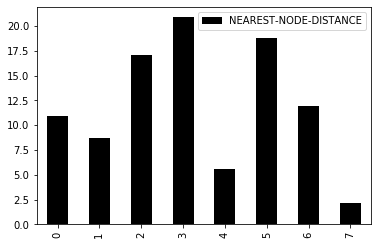

In [15]:
ax = pumps_df.plot.bar(y='NEAREST-NODE-DISTANCE', color='k')

The `NEAREST-NODE-DISTANCE` column in `pumps_df` represent `d1` in Figure 1.

### Set up `deaths_df` dataframe for analysis

In [16]:
deaths_df = deaths_df[['DEATHS', 'LON', 'LAT']]
deaths_df['DEATHS'].astype(int)
deaths_df['GLON'] = 0.00
deaths_df['GLAT'] = 0.00
deaths_df['NEAREST-NODE-DISTANCE'] = 0.00
deaths_df['NODE'] = 0
deaths_df['NODE'].astype(int)
deaths_df.dtypes

DEATHS                     int64
LON                      float64
LAT                      float64
GLON                     float64
GLAT                     float64
NEAREST-NODE-DISTANCE    float64
NODE                       int64
dtype: object

In [17]:
deaths_df.tail()

,DEATHS,LON,LAT,GLON,GLAT,NEAREST-NODE-DISTANCE,NODE
245,3,-0.137108,51.514526,0.0,0.0,0.0,0
246,2,-0.137065,51.514706,0.0,0.0,0.0,0
247,1,-0.138474,51.512311,0.0,0.0,0.0,0
248,1,-0.138123,51.511998,0.0,0.0,0.0,0
249,1,-0.137762,51.511856,0.0,0.0,0.0,0


In [18]:
%%time
for row in deaths_df.iterrows():
    dnode, ddistance = ox.get_nearest_node(G, \
                    (row[1]['LAT'],row[1]['LON']), \
                    return_dist=True)
    deaths_df.at[row[0], 'GLON'] = G.node[dnode]['x']
    deaths_df.at[row[0], 'GLAT'] = G.node[dnode]['y']
    deaths_df.at[row[0], 'NEAREST-NODE-DISTANCE'] = ddistance
    deaths_df.at[row[0], 'NODE'] = dnode

I0627 11:20:42.452098 139883350333248 utils.py:177] Found nearest node (25501340) to point (51.513418, -0.13793) in 0.02 seconds
I0627 11:20:42.459500 139883350333248 utils.py:177] Found nearest node (25501340) to point (51.513360999999996, -0.137883) in 0.01 seconds
I0627 11:20:42.466229 139883350333248 utils.py:177] Found nearest node (701600719) to point (51.513317, -0.137853) in 0.01 seconds
I0627 11:20:42.472620 139883350333248 utils.py:177] Found nearest node (701600719) to point (51.513262, -0.137812) in 0.01 seconds
I0627 11:20:42.479287 139883350333248 utils.py:177] Found nearest node (701600719) to point (51.513203999999995, -0.137767) in 0.01 seconds
I0627 11:20:42.485836 139883350333248 utils.py:177] Found nearest node (701600731) to point (51.513184, -0.137537) in 0.01 seconds
I0627 11:20:42.492146 139883350333248 utils.py:177] Found nearest node (25501330) to point (51.513359, -0.1382) in 0.01 seconds
I0627 11:20:42.498509 139883350333248 utils.py:177] Found nearest node 

CPU times: user 1.7 s, sys: 71.6 ms, total: 1.77 s
Wall time: 1.63 s


In [19]:
deaths_df['NEAREST-NODE-DISTANCE'].mean()

15.540299962255492

In [20]:
deaths_df.head()

,DEATHS,LON,LAT,GLON,GLAT,NEAREST-NODE-DISTANCE,NODE
0,3,-0.137930,51.513418,-0.137948,51.513408,1.694870,25501340
1,2,-0.137883,51.513361,-0.137948,51.513408,6.887505,25501340
2,1,-0.137853,51.513317,-0.137835,51.513236,9.138483,701600719
3,1,-0.137812,51.513262,-0.137835,51.513236,3.332689,701600719
4,4,-0.137767,51.513204,-0.137835,51.513236,5.861695,701600719


In [21]:
deaths_df.dtypes

DEATHS                     int64
LON                      float64
LAT                      float64
GLON                     float64
GLAT                     float64
NEAREST-NODE-DISTANCE    float64
NODE                       int64
dtype: object

In [22]:
deaths_df['NEAREST-NODE-DISTANCE'].mean()

15.540299962255492

In [23]:
deaths_df['NEAREST-NODE-DISTANCE'].min()

0.5721981045018782

In [24]:
deaths_df['NEAREST-NODE-DISTANCE'].max()

42.224050058475044

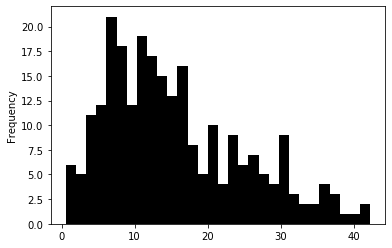

In [25]:
ax = deaths_df['NEAREST-NODE-DISTANCE'].plot.hist(bins=30, color='k')

## Step 4: Pairwise calculation of distance between `deaths_df` and `pumps_df` coordinates using a nested loop

In [26]:
%%time
import networkx as nx
# create empty list, lst, to store node and distance data 
#    from pairwise matching
new_list = []

# carry out pairwise calculations
# outer loop
for row_pump in pumps_df.iterrows():
    # inner loop
    for row_death in deaths_df.iterrows():
        death_node = row_death[1]['NODE'].astype(int)
        pump_node = row_pump[1]['NODE'].astype(int)
        distance = \
            nx.shortest_path_length(G, death_node, pump_node, weight='length') + \
            row_death[1]['NEAREST-NODE-DISTANCE'] + row_pump[1]['NEAREST-NODE-DISTANCE']
        new_list.append([death_node, pump_node, distance])     

CPU times: user 2.06 s, sys: 0 ns, total: 2.06 s
Wall time: 2.06 s


Let's create a new dataframe, `routes_df` from the list.

In [27]:
columns = ['DNODE','PNODE','PD_DISTANCE']
routes_df = pd.DataFrame(new_list, columns=columns)

In [28]:
routes_df.head()

,DNODE,PNODE,PD_DISTANCE
0,25501340,25473293,149.067774
1,25501340,25473293,154.260409
2,701600719,25473293,135.818387
3,701600719,25473293,130.012593
4,701600719,25473293,132.541599


In [29]:
routes_df['PD_DISTANCE'].min()

21.48201559582551

In [30]:
routes_df['PD_DISTANCE'].max()

873.7122731650767

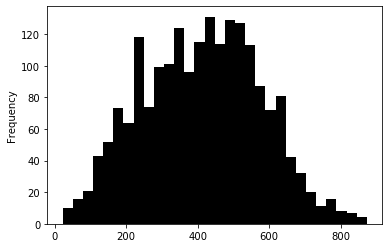

In [31]:
routes_df['PD_DISTANCE'].plot.hist(bins=30, color='k')

### Explanation of algorithm for pair-wise calculations

This code snippet below obtains the total distance, `d1 + d2 + d3`.

`distance = \`  
      `nx.shortest_path_length(G, death_node, pump_node, weight='length') + \  `    
      `row_death[1]['DISTANCE'] + row_pump[1]['DISTANCE']`

By this time we have obtained three sets of distance values, `d1`, `d2` and `d3` (see Figure 2 below):
1. <font color=red>`d1`</font> = distance in meters between coordinates of an actual pump and an OSMnx node from graph, `G` from `row_death[1]['DISTANCE']`
2. <font color=red>`d2`</font> = distance in meters between coordinates of a death location and an OSMnx node from graph, `G` from `row_pump[1]['DISTANCE']`
3. <font color=red>`d3`</font> = distance in meters between coordinates of two OSMnx nodes (pump and death location, or `PNODE` and `DNODE`, respectively in the `routes_df` dataframe) from <font color=red>`nx.shortest_path_length(G, dnode, pnode, weight='length')`</font>

**Figure 2.** Diagram describing the measurement of node to node distance.

![](images/osmnx2.png)

### Walkability Assumption, 400 meters

Let's assume that the residents of Soho district would be willing to walk 400 meters to fetch water from each pump by setting a filter of 400 meters or less as "walkable". Let's create a new dataframe, `routes400m_df`, containing node-to-node distance values <= 400 meters.

In [32]:
routes400m_df = routes_df[routes_df['PD_DISTANCE']<400]

Let's inspect that filtered dataframe, `routes2_df`. 

After filtering, how many rows did we end up with?

In [33]:
routes400m_df.head()

,DNODE,PNODE,PD_DISTANCE
0,25501340,25473293,149.067774
1,25501340,25473293,154.260409
2,701600719,25473293,135.818387
3,701600719,25473293,130.012593
4,701600719,25473293,132.541599


We can compare `routes_df` and `routes400m_df` for number of records easily using the `print()` statement below.

In [34]:
print('routes_df record count (unfiltered): ', len(routes_df), "\n",\
      'routes400m_df record count (filtered, 400 meters): ', len(routes400m_df))

routes_df record count (unfiltered):  2000 
 routes400m_df record count (filtered, 400 meters):  929


### Under the hood: Visualizing randomly sampled node-to-node distances from computations above

Let's see what's happening under the hood by visualizing some randomly sampled routes between death and pump points. Let's look at three random samples. We will use a "random choice" selected from the python package, `numpy`. To keep the pump node constant for each three samples, we will place the random pump code outside the loop.

I0627 11:21:05.480092 139883350333248 utils.py:177] Begin plotting the graph...
I0627 11:21:05.661583 139883350333248 utils.py:177] Created GeoDataFrame "unnamed_edges" from graph in 0.18 seconds
I0627 11:21:05.862302 139883350333248 utils.py:177] Drew the graph edges in 0.07 seconds


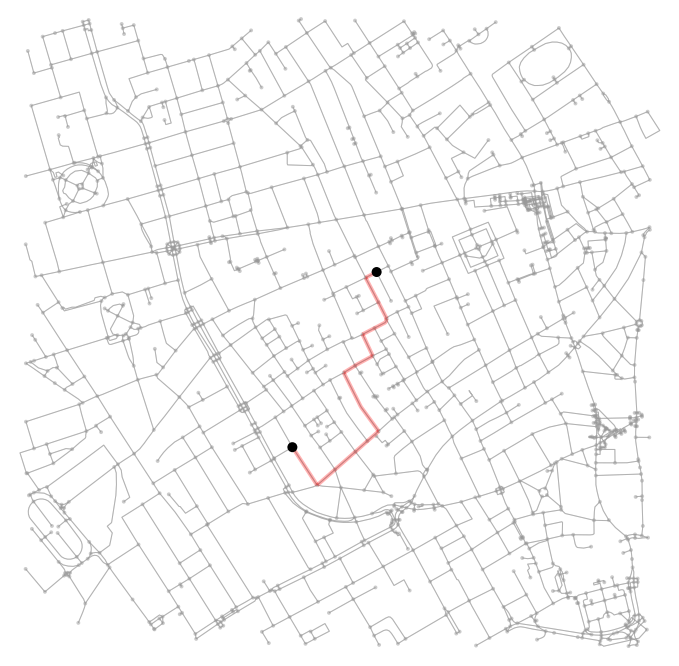

I0627 11:21:06.105297 139883350333248 utils.py:177] Showed the plot in 0.18 seconds
I0627 11:21:06.106818 139883350333248 utils.py:177] Begin plotting the graph...
I0627 11:21:06.225316 139883350333248 utils.py:177] Created GeoDataFrame "unnamed_edges" from graph in 0.12 seconds


Random pair number 1, death node=25502544, pump_node=25257692


I0627 11:21:06.430526 139883350333248 utils.py:177] Drew the graph edges in 0.07 seconds


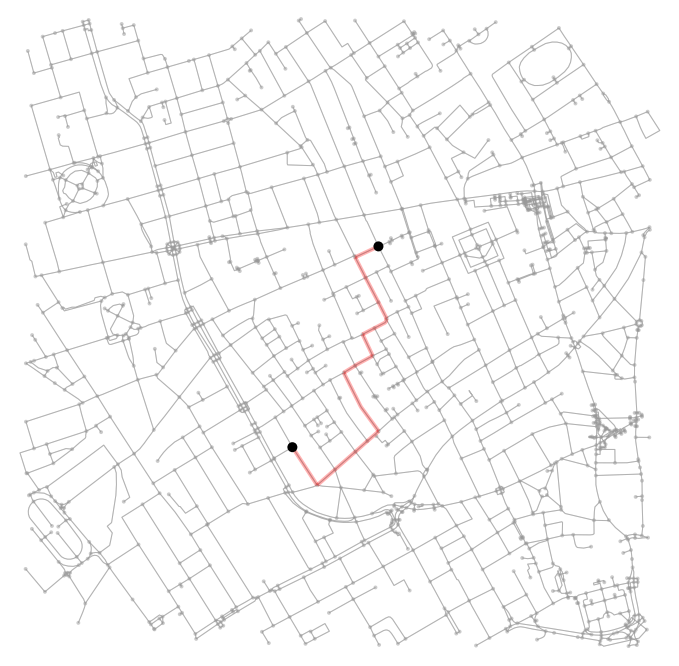

I0627 11:21:06.670458 139883350333248 utils.py:177] Showed the plot in 0.18 seconds
I0627 11:21:06.671648 139883350333248 utils.py:177] Begin plotting the graph...
I0627 11:21:06.788686 139883350333248 utils.py:177] Created GeoDataFrame "unnamed_edges" from graph in 0.12 seconds


Random pair number 2, death node=9521022, pump_node=25257692


I0627 11:21:06.998338 139883350333248 utils.py:177] Drew the graph edges in 0.07 seconds


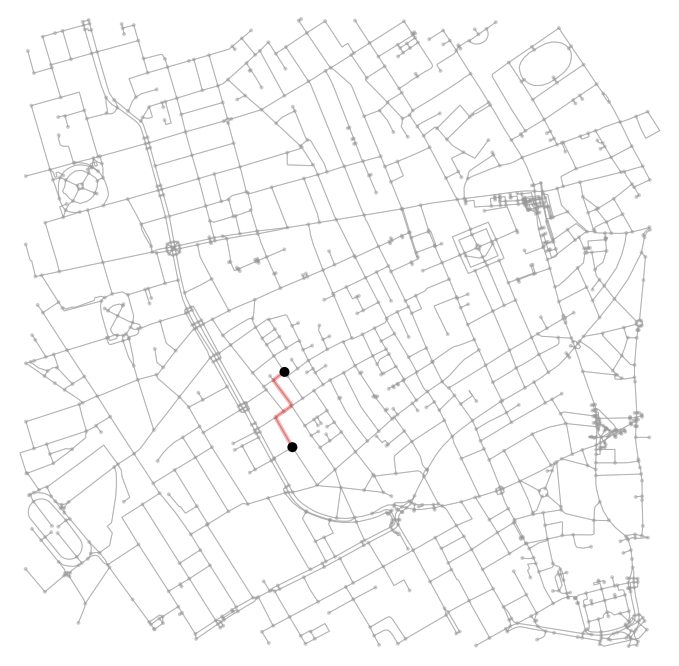

I0627 11:21:07.241363 139883350333248 utils.py:177] Showed the plot in 0.18 seconds


Random pair number 3, death node=2784434327, pump_node=25257692
CPU times: user 2.16 s, sys: 455 ms, total: 2.61 s
Wall time: 1.76 s


In [35]:
%%time
import numpy as np

pump_node = 25257692 # pump #8

for i in range(3):
    death_node = np.random.choice(routes400m_df['DNODE'].unique())
    route = nx.shortest_path(G, death_node, pump_node)
    fig, ax = ox.plot_graph_route(G, route, fig_height=12, \
                        node_alpha=0.5, edge_alpha=0.5, \
                        orig_dest_node_color='black', \
                        orig_dest_node_alpha=1,\
                        route_alpha=0.3)
    print("Random pair number "+str(i+1)+\
          ", death node="+str(death_node)+", pump_node="+str(pump_node))

In [36]:
routes400m_df.to_pickle('outputs/routes400m_df.pickle')

You can re-run the code above to see more random pairs.

### Updating `pumps_df` with mean distance values from `d1 + d2 + d3`

Let's store the mean distances between each pump and death locations from `routes_df` to `pumps_df`.

In [37]:
routes_df.head()

,DNODE,PNODE,PD_DISTANCE
0,25501340,25473293,149.067774
1,25501340,25473293,154.260409
2,701600719,25473293,135.818387
3,701600719,25473293,130.012593
4,701600719,25473293,132.541599


In [38]:
pumps_df.head()

,FID,LON,LAT,GLON,GLAT,NEAREST-NODE-DISTANCE,NODE,DEATHS-MEAN-DISTANCE
0,250,-0.136668,51.513341,-0.136533,51.513391,10.882904,25473293,0.0
1,251,-0.139586,51.513876,-0.139462,51.513861,8.746021,21665926,0.0
2,252,-0.139671,51.514906,-0.139904,51.514855,17.076661,4684520654,0.0
3,253,-0.131630,51.512354,-0.131466,51.512196,20.870820,107807,0.0
4,254,-0.133594,51.512139,-0.133606,51.512189,5.593686,348875443,0.0


In [39]:
for row in pumps_df.iterrows():
    mean_distance = \
        routes400m_df.loc[routes_df['PNODE'] == row[1]['NODE']]['PD_DISTANCE'].mean()
    pumps_df.at[row[0], 'DEATHS-MEAN-DISTANCE'] = mean_distance
    print("Pump "+str(row[0])+":\n ","Node ID: ", row[1]['NODE'].astype(int)\
          ,"\n","Mean Distance: ", mean_distance, "meters")


Pump 0:
  Node ID:  25473293 
 Mean Distance:  183.91367768355752 meters
Pump 1:
  Node ID:  21665926 
 Mean Distance:  258.01782890631273 meters
Pump 2:
  Node ID:  4684520654 
 Mean Distance:  342.39989338459606 meters
Pump 3:
  Node ID:  107807 
 Mean Distance:  354.6506675663533 meters
Pump 4:
  Node ID:  348875443 
 Mean Distance:  289.56765788952646 meters
Pump 5:
  Node ID:  25473300 
 Mean Distance:  286.02874989323976 meters
Pump 6:
  Node ID:  1663004187 
 Mean Distance:  349.36807531729005 meters
Pump 7:
  Node ID:  25257692 
 Mean Distance:  307.1348953308087 meters


Which of the 8 pumps has the shortest mean distance?

In [40]:
pumps_df

,FID,LON,LAT,GLON,GLAT,NEAREST-NODE-DISTANCE,NODE,DEATHS-MEAN-DISTANCE
0,250,-0.136668,51.513341,-0.136533,51.513391,10.882904,25473293,183.913678
1,251,-0.139586,51.513876,-0.139462,51.513861,8.746021,21665926,258.017829
2,252,-0.139671,51.514906,-0.139904,51.514855,17.076661,4684520654,342.399893
3,253,-0.131630,51.512354,-0.131466,51.512196,20.870820,107807,354.650668
4,254,-0.133594,51.512139,-0.133606,51.512189,5.593686,348875443,289.567658
5,255,-0.135919,51.511542,-0.135762,51.511404,18.794758,25473300,286.028750
6,256,-0.133962,51.510019,-0.133994,51.510125,11.951782,1663004187,349.368075
7,257,-0.138199,51.511295,-0.138178,51.511281,2.167033,25257692,307.134895


> What does the column `DEATHS-MEAN-DISTANCE` mean?

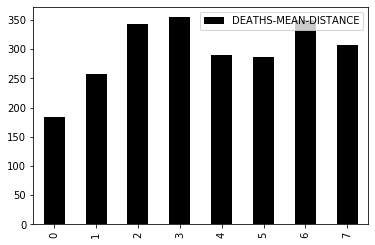

In [41]:
ax = pumps_df.plot.bar(y='DEATHS-MEAN-DISTANCE', color='k')

## Step 5: Create `folium` map to show which pumps have mean shortest walkable distance values to most death points

### Recreate Notebook 1 `folium` map and markers for pumps and deaths

In [52]:
import pandas as pd
import folium

# let's import the folium plugins
from folium import plugins

# we already have pumps_df and deaths_df

SOHO_COORDINATES = (51.513578, -0.136722)

map1 = folium.Map(location=SOHO_COORDINATES, zoom_start=17)

TileLayer1 = folium.TileLayer('stamentoner')
TileLayer2 = folium.TileLayer('cartodbpositron')

TileLayer1.layer_name = 'Stamen Toner'
TileLayer2.layer_name = 'CartoDB Positron'

TileLayer1.add_to(map1)
TileLayer2.add_to(map1)

fg = folium.FeatureGroup(name='All Markers')
map1.add_child(fg)

g1 = plugins.FeatureGroupSubGroup(fg, 'Death Locations')
map1.add_child(g1)

g2 = plugins.FeatureGroupSubGroup(fg, 'Pump Locations')
map1.add_child(g2)

g3 = plugins.FeatureGroupSubGroup(fg, 'Mean Center Point')
map1.add_child(g3)

g4 = plugins.FeatureGroupSubGroup(fg, 'Mean Distance')
map1.add_child(g4)

locationlist = deaths_df[["LAT","LON"]].values.tolist()
radiuslist = deaths_df[["DEATHS"]].values.tolist()

# Iterate through the rows of the cholera deaths data frame 
#    and add each cholera death circle marker to map1
for i in range(0, len(locationlist)):

    # Create a popup for each marker
    # Each marker will show point information and 
    #   number of deaths in that location.    
    popup = folium.Popup('Location: '+'('+str(locationlist[i][0])+\
                         ', '+str(locationlist[i][1])+')'+\
                         '<br/>'+\
                        'Deaths: '+ str(radiuslist[i][0]))
    
    # Add each circle marker with popup representing 
    #   a location with deaths to map1
    death_marker = folium.CircleMarker(
                    location=locationlist[i], \
                    radius=radiuslist[i], \
                    popup=popup, \
                    color='black', \
                    weight=1, \
                    fill=True, \
                    fill_color='red', \
                    fill_opacity=1) #.add_to(map1)
    death_marker.add_to(g1)

# Iterate through the rows of the pumps_df data frame 
#   and add each water pump to map1
for each in pumps_df.iterrows():
    
    # Create a popup for each marker
    # Each marker will show pump location information
    popup = folium.Popup('Location: '+'('+str(each[1]['LAT'])+', '+str(each[1]['LON'])+')')

    # Add each circle marker with popup representing 
    #   a pump location to map1
    pump_marker = folium.RegularPolygonMarker([each[1]['LAT'],each[1]['LON']], \
                    color='black', \
                    weight=1,\
                    fill_opacity=1, \
                    fill_color='blue', \
                    number_of_sides=4, \
                    popup=popup, \
                    radius=10) #.add_to(map1)
    pump_marker.add_to(g2)

mean_center_df = pd.read_pickle('outputs/mean_center_df.pickle')
mean_center_POINT = (mean_center_df['mean_LAT'], mean_center_df['mean_LON'])

meancenter_marker = folium.CircleMarker(
            location=mean_center_POINT, \
            color='black', \
            weight=2, \
            fill_opacity=1, \
            fill_color="yellowgreen", \
            popup=folium.Popup('Mean Center Point: '+ \
                str(mean_center_POINT)), \
            radius=10).add_to(map1)
meancenter_marker.add_to(g3)

for row in pumps_df.iterrows():
    # add each water pump mean distance to map1 (divide by 5 to make circle smaller)
    meandistance_marker = folium.Circle(location=[row[1]['LAT'],row[1]['LON']], \
                  popup='Pump '+str(row[1]['NODE'].astype(int)), \
                  radius=(row[1]['DEATHS-MEAN-DISTANCE'])/5).add_to(map1)
    meandistance_marker.add_to(g4)


# let's use the "Fullscreen" plugin
# add the button to the top right corner
plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True
).add_to(map1)

# add the layer control
folium.LayerControl(collapsed=False).add_to(map1)

map1

## Putting it All Together

Now that you have read all the narratives and code explanations, and seen the outputs of all the code, we can put all these together into one "program".

In [172]:
import pandas as pd
import folium
import osmnx as ox
import networkx as nx
import numpy as np

# set some configuration parameters for osmnx
# print version of package
ox.config(use_cache=True, log_console=True)
ox.config(log_file=True, log_console=True, use_cache=True)

I0626 12:29:55.259618 139831780292416 utils.py:177] Configured osmnx


### Folium Map Basic Plotting

In [173]:
deaths_df = pd.read_csv('resources/cholera_deaths.csv')
pumps_df = pd.read_csv('resources/pumps.csv')

SOHO_COORDINATES = (51.513578, -0.136722)

map1 = folium.Map(location=SOHO_COORDINATES, zoom_start=17)

folium.TileLayer('cartodbpositron').add_to(map1)

locationlist = deaths_df[["LAT","LON"]].values.tolist()
radiuslist = deaths_df[["DEATHS"]].values.tolist()

# Iterate through the rows of the cholera deaths data frame 
#    and add each cholera death circle marker to map1
for i in range(0, len(locationlist)):

    # Create a popup for each marker
    # Each marker will show point information and 
    #   number of deaths in that location.    
    popup = folium.Popup('Location: '+'('+str(locationlist[i][0])+\
                         ', '+str(locationlist[i][1])+')'+\
                         '<br/>'+\
                        'Deaths: '+ str(radiuslist[i][0]))
    
    # Add each circle marker with popup representing 
    #   a location with deaths to map1
    folium.CircleMarker(
                    location=locationlist[i], \
                    radius=radiuslist[i], \
                    popup=popup, \
                    color='black', \
                    weight=1, \
                    fill=True, \
                    fill_color='red', \
                    fill_opacity=1).add_to(map1)

# Iterate through the rows of the pumps_df data frame 
#   and add each water pump to map1
for each in pumps_df.iterrows():
    
    # Create a popup for each marker
    # Each marker will show pump location information
    popup = folium.Popup('Location: '+'('+str(each[1]['LAT'])+', '+str(each[1]['LON'])+')')

    # Add each circle marker with popup representing 
    #   a pump location to map1
    folium.RegularPolygonMarker([each[1]['LAT'],each[1]['LON']], \
                    color='black', \
                    weight=1,\
                    fill_opacity=1, \
                    fill_color='blue', \
                    number_of_sides=4, \
                    popup=popup, \
                    radius=10).add_to(map1)



### Mean Center

In [174]:
# Add mean center marker weighted by deaths
deaths_df['product_LAT'] = deaths_df['LAT'] * deaths_df['DEATHS']
deaths_df['product_LON'] = deaths_df['LON'] * deaths_df['DEATHS']

# Let's copy this dataframe to a new one which we can save (pickle)
deaths_mean_center_df = deaths_df

mean_LON = np.sum(deaths_df['product_LON'])/np.sum(deaths_df['DEATHS'])
mean_LAT = np.sum(deaths_df['product_LAT'])/np.sum(deaths_df['DEATHS'])
mean_center_POINT = (mean_LAT, mean_LON)

folium.CircleMarker(
            location=mean_center_POINT, \
            color='black', \
            weight=2, \
            fill_opacity=1, \
            fill_color="yellowgreen", \
            popup=folium.Popup('Mean Center Point: '+ \
                str(mean_center_POINT)), \
            radius=10).add_to(map1)

### OSMNx

In [176]:
G = ox.load_graphml(filename='soho.graphml', folder='resources')

pumps_df = pumps_df[['LON', 'LAT']]
pumps_df['GLON'] = 0.00
pumps_df['GLAT'] = 0.00
pumps_df['NEAREST-NODE-DISTANCE'] = 0.00
pumps_df['NODE'] = 0
pumps_df['NODE'].astype(int)
pumps_df['DEATHS-MEAN-DISTANCE'] = 0.00

for row in pumps_df.iterrows():
    pnode, pdistance = \
       ox.get_nearest_node(G, (row[1]['LAT'],row[1]['LON']), return_dist=True)
    pumps_df.at[row[0], 'GLON'] = G.node[pnode]['x']
    pumps_df.at[row[0], 'GLAT'] = G.node[pnode]['y']
    pumps_df.at[row[0], 'NEAREST-NODE-DISTANCE'] = pdistance # distance is provided in meters
    pumps_df.at[row[0], 'NODE'] = pnode

deaths_df = deaths_df[['DEATHS', 'LON', 'LAT']]
deaths_df['DEATHS'].astype(int)
deaths_df['GLON'] = 0.00
deaths_df['GLAT'] = 0.00
deaths_df['NEAREST-NODE-DISTANCE'] = 0.00
deaths_df['NODE'] = 0
deaths_df['NODE'].astype(int)

for row in deaths_df.iterrows():
    dnode, ddistance = ox.get_nearest_node(G, \
                    (row[1]['LAT'],row[1]['LON']), \
                    return_dist=True)
    deaths_df.at[row[0], 'GLON'] = G.node[dnode]['x']
    deaths_df.at[row[0], 'GLAT'] = G.node[dnode]['y']
    deaths_df.at[row[0], 'NEAREST-NODE-DISTANCE'] = ddistance
    deaths_df.at[row[0], 'NODE'] = dnode

# create empty list, lst, to store node and distance data 
#    from pairwise matching
new_list = []

# carry out pairwise calculations
for row_pump in pumps_df.iterrows():
    for row_death in deaths_df.iterrows():
        dnode = row_death[1]['NODE'].astype(int)
        pnode = row_pump[1]['NODE'].astype(int)
        distance = \
            nx.shortest_path_length(G, death_node, pump_node, weight='length') + \
            row_death[1]['NEAREST-NODE-DISTANCE'] + row_pump[1]['NEAREST-NODE-DISTANCE']
        new_list.append([death_node, pump_node, distance])
        
columns = ['DNODE','PNODE','PD_DISTANCE']
routes_df = pd.DataFrame(lst, columns=columns)

routes400m_df = routes_df[routes_df['PD_DISTANCE']<400]

for row_pump in pumps_df.iterrows():
    mean_distance = \
        routes400m_df.loc[routes_df['PNODE'] == row_pump[1]['NODE']]['PD_DISTANCE'].mean()
    pumps_df.at[row_pump[0], 'DEATHS-MEAN-DISTANCE'] = mean_distance

for row_pump in pumps_df.iterrows():
    #add each water pump circle to map1
    folium.Circle(location=[row_pump[1]['LAT'],row_pump[1]['LON']], \
                  popup='Pump '+str(row_pump[1]['NODE'].astype(int)), \
                  radius=(row_pump[1]['DEATHS-MEAN-DISTANCE'])/5).add_to(map1)
    
map1

I0626 12:40:16.461244 139831780292416 utils.py:177] Converting node and edge attribute data types
I0626 12:40:16.537520 139831780292416 utils.py:177] Loaded graph with 1,389 nodes and 3,900 edges in 0.29 seconds from "resources/soho.graphml"
I0626 12:40:16.623379 139831780292416 utils.py:177] Found nearest node (25473293) to point (51.513341, -0.136668) in 0.00 seconds
I0626 12:40:16.630439 139831780292416 utils.py:177] Found nearest node (21665926) to point (51.513876, -0.139586) in 0.01 seconds
I0626 12:40:16.637284 139831780292416 utils.py:177] Found nearest node (4684520654) to point (51.514905999999996, -0.13967100000000002) in 0.01 seconds
I0626 12:40:16.643622 139831780292416 utils.py:177] Found nearest node (107807) to point (51.512353999999995, -0.13163) in 0.01 seconds
I0626 12:40:16.650072 139831780292416 utils.py:177] Found nearest node (348875443) to point (51.512139000000005, -0.13359400000000002) in 0.01 seconds
I0626 12:40:16.656619 139831780292416 utils.py:177] Found n

## Congratulations!

You have just gained some expertise in:
1. The Cholera Outbreak in 1854 London
2. Use of a few Python packages for data analysis and visualization: `pandas`, `folium`
3. Use of the Open Street Maps - NetworkX package, `osmnx` for street network type analysis
4. Generating value out of information sources (mortality and street network data)

## References

1. Boeing, Geoff. OSMnx: Python for Street Networks. URL: https://geoffboeing.com/2016/11/osmnx-python-street-networks/
2. Networkx. URL: https://networkx.github.io/
3. Shiode S. Revisiting John Snow's map: network-based spatial demarcation of cholera area. International Journal of Geographical Information Science Volume 26, 2012 - Issue 1. URL: https://www.tandfonline.com/doi/abs/10.1080/13658816.2011.577433.

*For case study suggestions for improvement, please contact Herman Tolentino, Jan MacGregor, James Tobias or Zhanar Haimovich.*